# 基于PaddlePaddle的MNIST手写数字识别
### 作者：张强   
### 微信号：MrZhangQiang2019
### 请关注公众号，免费获得更多的学习教程和资料
![](https://ai-studio-static-online.cdn.bcebos.com/c1ef6aea9943477c83541807e56c5066b0a16810dda843839ebe0edc3968748f)

### <a href="https://blog.csdn.net/u013538542" target="_blank">CSDN博客</a>
### <a href="https://github.com/21-projects-for-deep-learning" target="_blank">Github主页</a>

In [6]:
!pip install paddlepaddle==1.4.0

In [4]:
import numpy as np 
print(np.__version__) 

1.15.4


In [5]:
import matplotlib 
print(matplotlib.__version__) 

2.2.3


In [1]:
import paddle
print(paddle.__version__) 

1.4.0


In [3]:
# 查看个人持久化工作区文件
!ls /home/aistudio/data/data65

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


# 下载数据集

In [1]:
import paddle

train = paddle.dataset.mnist.train()
test = paddle.dataset.mnist.test()

In [24]:
# 数据集返回的是一个生成器，数据类型是reader
train()

<generator object reader_creator.<locals>.reader at 0x7f4d70c77e60>

In [4]:
train_imgs = [img for img in train()]
test_imgs = [img for img in test()]
print("train_length={}, test_length={}".format(len(train_imgs), len(test_imgs)))

train_length=60000, test_length=10000


# 随机显示几张图像

In [72]:
import random

# 随机从数组中选择5张图像
random_5_imgs = random.sample(train_imgs, 5)

# PaddlePaddle读取出来的数据是由一个个元组作为数组元素
# 每个元组的第一位为图像的向量，第二位是该向量对应的标签
vector = random_5_imgs[0][0]
label = random_5_imgs[0][1]
print("vector.shape={}, label={}".format(vector.shape, label))

vectors = []
labels = []
for vector, label in random_5_imgs:
    # 将每张图像向量转换成图像矩阵
    vectors.append(vector.reshape((28,28)))
    labels.append(label)

print("第一张图像的.shape是{}".format(vectors[0].shape))   

vector.shape=(784,), label=6
第一张图像的.shape是(28, 28)


图像对应的标签是[6, 6, 6, 1, 6]。


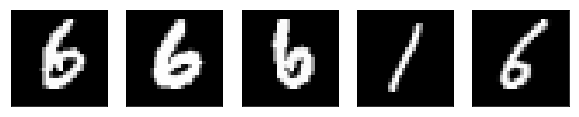

In [74]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 
 
# 创建一个10x5大小的绘图对象
fig = plt.figure(figsize=(10, 5)) 
# 遍历5次，因为我们只随机选择了5张图像，
# 所以这里显示的图像取决于每次随机的图像而变化
# 每次的图像显示的肯定不一样
for i in range(5): 
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(vectors[i:i+1], (28, 28)), cmap='gray') 
print("图像对应的标签是{}。".format(labels))

# 创建神经网络模型

In [2]:
import paddle.fluid as fluid
import numpy as np

# 表示0到9的共10个数字
num_classes = 10

# 我们使用CPU来训练模型
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

# 输入的原始图像数据，大小为28*28*1
X = fluid.layers.data(name="img", shape=[1, 28, 28], dtype=np.float32)
# 输入的原始图像数据的标签
y = fluid.layers.data(name="label", shape=[1], dtype=np.int64)

# 创建输出层，以softmax为激活函数的全连接层，输出层的大小必须为数字的个数10
# fc表示全连接层（fully connected layer）
predict = fluid.layers.fc(input=X, size=num_classes, act="softmax")

# 使用类交叉熵函数计算predict和y之间的损失函数
cost = fluid.layers.cross_entropy(input=predict, label=y)
# 计算平均损失
avg_loss = fluid.layers.mean(cost)
# 计算分类准确率
acc = fluid.layers.accuracy(input=predict, label=y)

# 告知网络传入的数据分为两部分，第一部分是img值X，第二部分是label值y
feeder = fluid.DataFeeder(feed_list=[X, y], place=place)
# 选择Adam优化器，使损失最小化
optimizer = fluid.optimizer.Adam(learning_rate=0.001).minimize(avg_loss)


# 训练模型

In [3]:
# 创建执行器
executor = fluid.Executor(place)
executor.run(fluid.default_startup_program())

# 设置 main_program 和 test_program
main_program = fluid.default_main_program()
test_program = fluid.default_main_program().clone(for_test=True)


In [4]:
def test_loss_acc(test_program, test_reader, test_feeder):
    """
    在训练模型时，计算测试集的损失值和精确度
    """
    loss_arr = []
    accuracy_arr = []
    # 开始迭代测试loss和acc
    for test_data in test_reader():
        # 在Paddle中推理计算loss和acc
        _loss, _acc = executor.run(test_program, 
                                   feed=test_feeder.feed(test_data), 
                                   fetch_list=[avg_loss, acc])
        loss_arr.append(float(_loss))
        accuracy_arr.append(float(_acc))
    # 获得测试数据集上的准确率和损失值的均值
    loss_mean = np.array(loss_arr).mean()
    accuracy_mean = np.array(accuracy_arr).mean()
    return loss_mean, accuracy_mean

In [5]:
BATCH_SIZE = 64
# 通过batch返回数据集的总数量除以64的批次数，所以就是 
# batch的数量是 60000 / 64 = 937.5 向上取整等于938
train_reader = paddle.batch(paddle.reader.shuffle(train, buf_size=500), batch_size=BATCH_SIZE)
# batch的数量是 10000 / 64 = 156.25 向上取整等于157
test_reader = paddle.batch(paddle.reader.shuffle(test, buf_size=500), batch_size=BATCH_SIZE)

train_reader_length = len([1 for _ in train_reader()])
test_reader_length = len([1 for _ in test_reader()])
print("train_reader分了{}个batch，test_reader分了{}个batch。".format(train_reader_length, test_reader_length))

train_reader分了938个batch，test_reader分了157个batch。


In [6]:
epochs = 5
saved_model_filename = "mnist.inference.model" 
result_arr = []     
step = 0 
# 开始迭代训练模型 
for epoch_id in range(epochs): 
    # 遍历训练集数据 
    for step_i, data in enumerate(train_reader()): 
         
        # 训练模型 
        metrics = executor.run(main_program,  
                               feed=feeder.feed(data),  
                               fetch_list=[avg_loss, acc]) 
         
        # 每训练100次打印一次日志 
        if step % 100 == 0: 
            loss_train, accuracy_train = metrics[0][0], metrics[1][0]
            print("Train Epoch {}, step_i {}, loss {}, acc {}".format(epoch_id, 
                                                                 step, 
                                                                 metrics[0][0], 
                                                                 metrics[1][0])) 
            # 评估测试集的分类效果 
            loss_val, accuracy_val = test_loss_acc(test_program, test_reader, feeder) 
            print("Valid Epoch {}, step_i {}，loss {}，acc {}".format(epoch_id,  
                                                                 step,  
                                                                 loss_val, 
                                                                 accuracy_val)) 
        step += 1 
         
        result_arr.append((epoch_id, loss_val, accuracy_val, loss_train, accuracy_train)) 
         
        # 保存训练好的模型参数用于预测 
        fluid.io.save_inference_model(saved_model_filename, 
                                      ["img"],  
                                      [predict],  
                                      executor, 
                                      model_filename=None, 
                                      params_filename=None) 

Train Epoch 0, step_i 0, loss 3.662783145904541, acc 0.0625
Valid Epoch 0, step_i 0，loss 0.9381991980751608，acc 0.7200437898089171
Train Epoch 0, step_i 100, loss 0.4590408504009247, acc 0.890625
Valid Epoch 0, step_i 100，loss 0.40269697471788735，acc 0.8835589171974523
Train Epoch 0, step_i 200, loss 0.31612035632133484, acc 0.921875
Valid Epoch 0, step_i 200，loss 0.3462911493079677，acc 0.8993829617834395
Train Epoch 0, step_i 300, loss 0.2031039297580719, acc 0.9375
Valid Epoch 0, step_i 300，loss 0.31732828160569926，acc 0.9067476114649682
Train Epoch 0, step_i 400, loss 0.35602274537086487, acc 0.90625
Valid Epoch 0, step_i 400，loss 0.3001301080510495，acc 0.9129179936305732
Train Epoch 0, step_i 500, loss 0.6872471570968628, acc 0.8125
Valid Epoch 0, step_i 500，loss 0.29144867859590967，acc 0.9171974522292994
Train Epoch 0, step_i 600, loss 0.32285529375076294, acc 0.921875
Valid Epoch 0, step_i 600，loss 0.2795794809082891，acc 0.9185907643312102
Train Epoch 0, step_i 700, loss 0.335185

In [20]:
# 选择效果最好的
best_predict = sorted(result_arr, key=lambda ele:float(ele[1]))[0]
print("Valid Loss {}, Acc {:.5f}%.".format(best_predict[1], float(best_predict[2])*100))
print("Train Loss {}, Acc {:.5f}%.".format(best_predict[3], float(best_predict[4])*100))

Valid Loss 0.19667905686529957, Acc 94.30732%.
Train Loss 0.1873813271522522, Acc 93.75000%.


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

result_np = np.array(result_arr)
loss_val = result_np[:,1]
accuracy_val = result_np[:,2] 
loss_train = result_np[:,3]
accuracy_train = result_np[:,4]

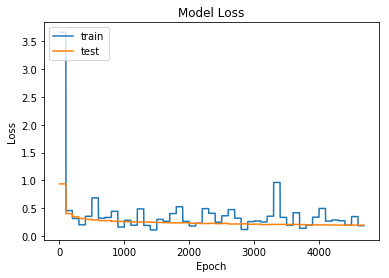

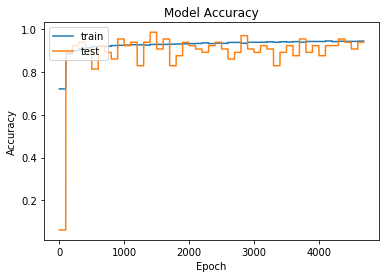

In [46]:
# 绘制训练集和验证集的损失值 
plt.plot(loss_train) 
plt.plot(loss_val) 
plt.title('Model Loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show() 

# 绘制训练集和验证集的精确度 
plt.plot(accuracy_val) 
plt.plot(accuracy_train) 
plt.title('Model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show() 

# 随便选择一张图像来测试模型

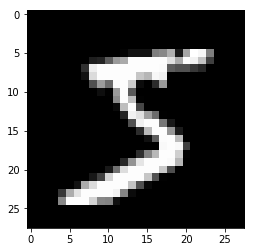

这张图像的标签是5。


In [53]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
 
img_matrix = next(train())[0].reshape(28, 28) 
img_label = next(train())[1]

imgplot = plt.imshow(img_matrix, cmap="gray") 
plt.show() 
print("这张图像的标签是{}。".format(img_label))

In [73]:
# 创建执行器
test_executor = fluid.Executor(place)
test_executor.run(fluid.default_startup_program())

inference_scope = fluid.core.Scope()
with fluid.scope_guard(inference_scope):
    # 加载模型
    [inference_program, feed_target_names, fetch_targets] = \
    fluid.io.load_inference_model(saved_model_filename, test_executor, None, None)
    
    # 运行推理图像
    results = test_executor.run(inference_program, 
                                feed={feed_target_names[0]: img_matrix.reshape(1,1,28,28)}, 
                                fetch_list=fetch_targets)
    # 预测的标签
    predicted_label = np.argmax(results[0][0])
    # 预测概率
    predicted_prob = max(results[0][0])
    print("Accuracy = {}, Label = {}".format(predicted_prob, predicted_label))

Accuracy = 0.9278314113616943, Label = 5


In [25]:
!ls -lha mnist.inference.model

total 112K
drwxrwxrwx  2 root     root 4.0K May  4 07:12 .
drwxrwxrwx 16 aistudio 1000 4.0K May  4 10:31 ..
-rwxrwxrwx  1 root     root   64 May  4 10:00 fc_0.b_0
-rwxrwxrwx  1 root     root  31K May  4 10:00 fc_0.w_0
-rwxrwxrwx  1 root     root   64 May  4 07:12 fc_3.b_0
-rwxrwxrwx  1 root     root  31K May  4 07:12 fc_3.w_0
-rwxrwxrwx  1 root     root  31K May  4 10:00 __model__


### 请关注公众号，免费获得更多的学习教程和资料
![](https://ai-studio-static-online.cdn.bcebos.com/c1ef6aea9943477c83541807e56c5066b0a16810dda843839ebe0edc3968748f)

### <a href="https://blog.csdn.net/u013538542" target="_blank">CSDN博客</a>
### <a href="https://github.com/21-projects-for-deep-learning" target="_blank">Github主页</a>